In [2]:
import numpy as np
import pandas as pd 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [3]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
data = pd.read_csv('file.path')
data.drop(['Volume', 'Volume MA', 'time'], inplace=True, axis=1) # ex 필요없는 피쳐 drop
data.head()

,open,high,low,close,Plot,VAR,VAR.1
0,26435.4,26439.9,26405.6,26411.3,26426.720866,-0.042607,-0.606106
1,26411.3,26422.3,26400.0,26411.9,26426.498211,-0.222656,-0.180049
2,26411.9,26411.9,26370.1,26397.9,26424.779105,-1.719106,-1.496450
3,26397.9,26421.8,26378.8,26417.2,26424.729034,-0.050071,1.669035
4,26417.2,26488.3,26417.1,26463.4,26428.231182,3.502148,3.552218


In [5]:
scaler = MinMaxScaler()

input_features = ['open', 'high', 'low', 'close', 'Plot', 'VAR', 'VAR.1'] # MinMax정규화 사용할 피쳐 셀렉
data[input_features] = scaler.fit_transform(data[input_features])

sequence_length = 7 # 롤링윈도우 기준

train_size = int(len(data) * 0.7)
train_set = data[0:train_size]
test_set = data[train_size - sequence_length:]

In [6]:
# 롤링윈도우
def build_dataset(file, sequence_length):
    inputs = []
    labels = []

    for i in range(len(file) - sequence_length):
        inputs.append(file.iloc[i:i+sequence_length].values)
        labels.append(file.iloc[i+sequence_length]['close']) 

    return np.array(inputs), np.array(labels)

train_X, train_Y = build_dataset(train_set, sequence_length=sequence_length)
test_X, test_Y = build_dataset(test_set, sequence_length=sequence_length)

train_X_tensor = torch.FloatTensor(train_X)
train_Y_tensor = torch.FloatTensor(train_Y)

test_X_tensor = torch.FloatTensor(test_X)
test_Y_tensor = torch.FloatTensor(test_Y)

dataset = TensorDataset(train_X_tensor, train_Y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, drop_last=True)

In [7]:
class VIDYA_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=True):
        super(VIDYA_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out[:, -1, :])
        return out


In [8]:
input_size = 7 # 들어가는 인풋사이즈
hidden_size = 10
num_layers = 2
output_size = 1 # 아웃풋사이즈

model = VIDYA_LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [9]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

c:\Users\PC\anaconda3\envs\AI\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss 0.27662110328674316
loss 0.09423824399709702
loss 0.04627014696598053
loss 0.03599071502685547
loss 0.028293248265981674
loss 0.025239799171686172
loss 0.023586690425872803
loss 0.02038474753499031
loss 0.02797267772257328
loss 0.025979146361351013


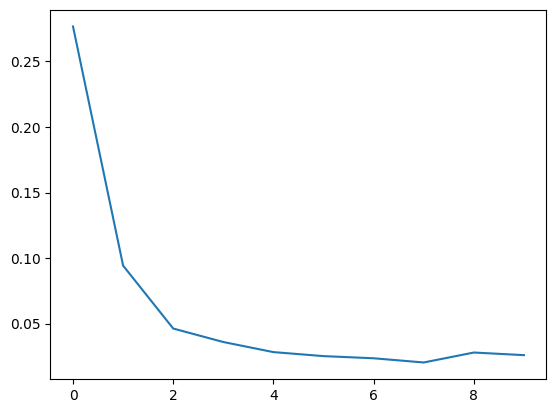

In [10]:
epochs = 100
loss_array = []

for epoch in range(epochs):

    for batch_idx, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out_put = model(x)
        loss = criterion(out_put, y)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("loss", loss.item())
        loss_array.append(loss.cpu().detach().numpy())

plt.plot(loss_array)
plt.show()
        

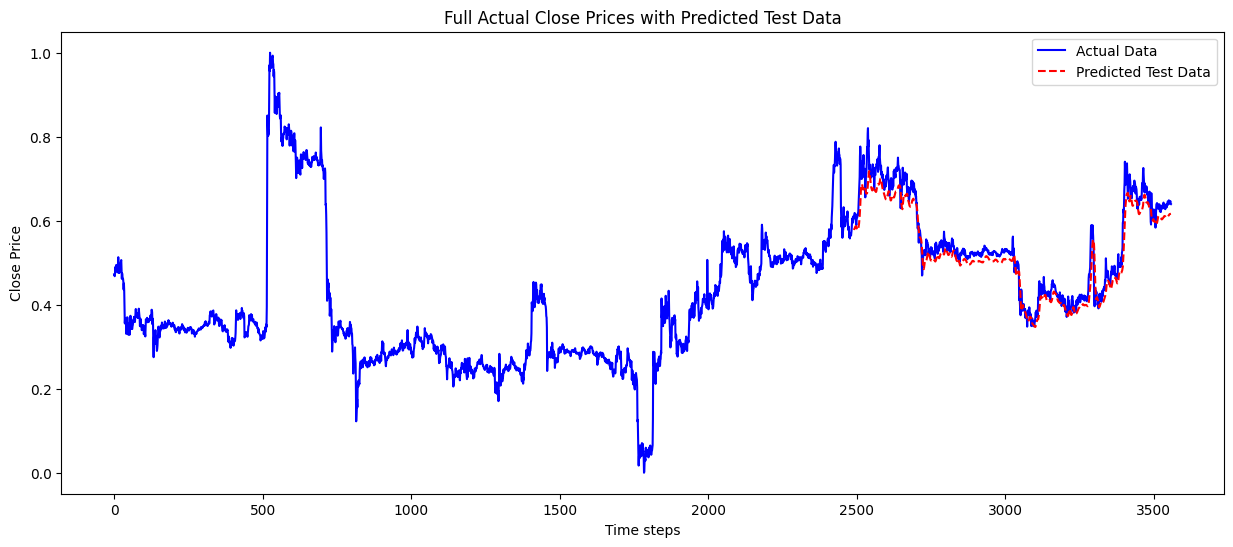

In [11]:
with torch.no_grad(): 
    model.eval() 
    test_inputs = torch.FloatTensor(test_X).to(device)
    predicted_test = model(test_inputs).cpu().numpy()

scaler.fit(data[['close']])

predicted_test_actual = scaler.inverse_transform(np.array(predicted_test).reshape(-1, 1))
 

plt.figure(figsize=(15,6))

plt.plot(data['close'].values, label='Actual Data', color='blue')

plt.plot(range(len(data) - len(predicted_test_actual), len(data)), predicted_test_actual, label='Predicted Test Data', color='red', linestyle='dashed')
plt.title("Full Actual Close Prices with Predicted Test Data")
plt.xlabel("Time steps")
plt.ylabel("Close Price")
plt.legend()
plt.show()